# Appendix: $\tau(x)$ validation for test geometries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import taufactor as tau

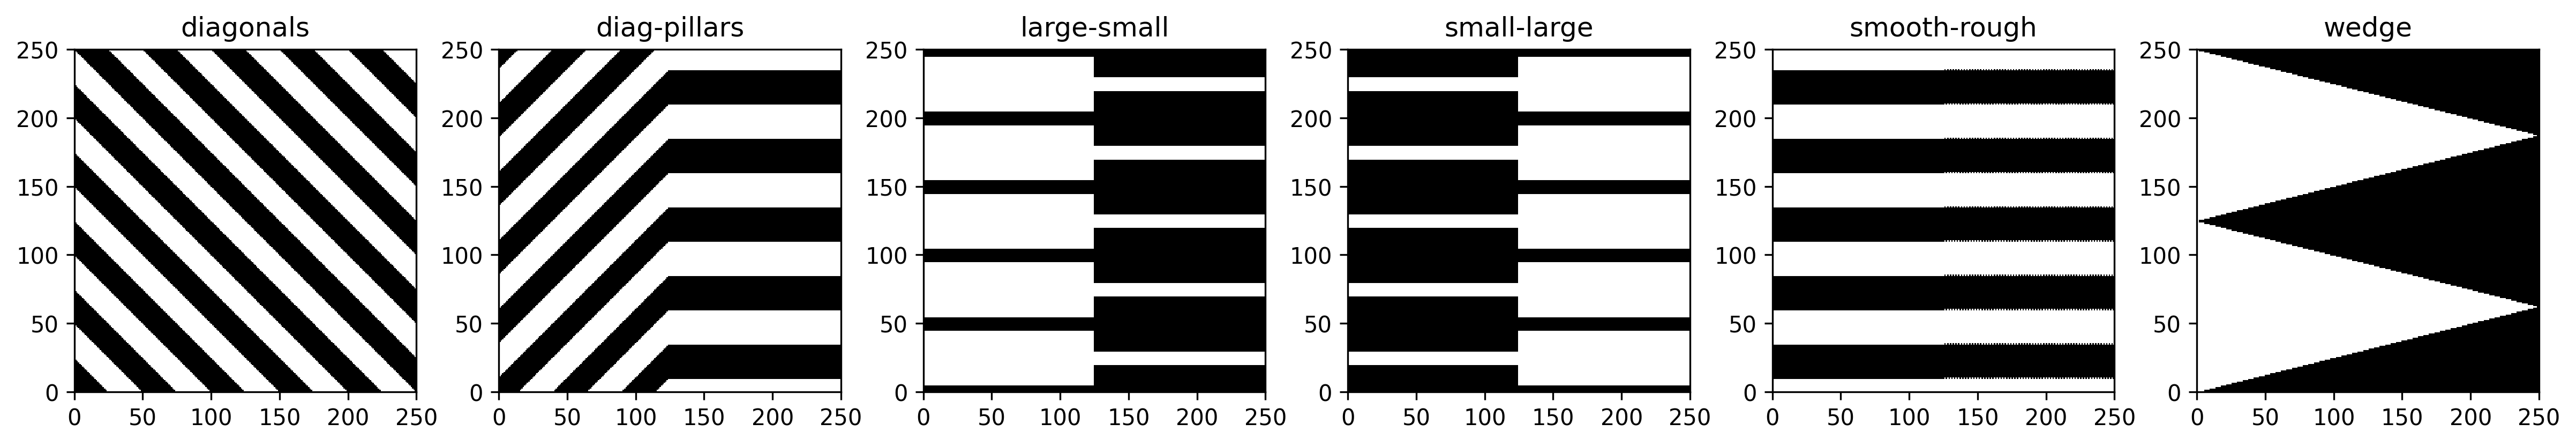

In [2]:
nx = 250
fields = {}

structures = ["diagonals", "diag-pillars", "large-small", "small-large", "smooth-rough", "wedge"]

cube_size = 25
x, y, z = np.ogrid[:nx, :nx, :1]

pattern = (((x + y + z) // cube_size) % 2)
fields["diagonals"] = pattern

pillars = x - x + ((y // cube_size) + (z // cube_size)) % 2
pattern = np.zeros((nx, nx, 1))
pattern[:125,:] = pillars[:125,:]
pattern[125:,:] = fields["diagonals"][:125,:]
fields["diag-pillars"] = np.roll(pattern[::-1,:,:], shift=10, axis=1)

pattern = np.zeros((nx, nx, 1))
pattern[:125,0:40] = 1
pattern[125:,15:25] = 1
pattern[:,50:100] = pattern[:,:50]
pattern[:,100:200] = pattern[:,:100]
pattern[:,200:250] = pattern[:,:50]
pattern = np.roll(pattern, shift=5, axis=1)
fields["large-small"] = pattern
fields["small-large"] = pattern[::-1,:,:].copy()

pattern = pillars.copy()
pattern[0::2, :, :] = np.roll(pattern[0::2, :, :], shift=1, axis=1)
pattern[:125,:] = pillars[:125,:]
fields["smooth-rough"] = np.roll(pattern, shift=10, axis=1)

pattern = np.zeros((nx, nx, 1))
mask = ((x+0.5)/nx + 4*(y+0.5)/nx < 2) & ((x+0.5)/nx - 4*(y+0.5)/nx < 0)
pattern[mask] = 1
pattern[:,125:] = pattern[:,:125][:,::-1]
pattern[-1,:] = 0
fields["wedge"] = pattern

fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(16, 8), dpi=300)
for i, structure in enumerate(structures):
    data2d = fields[structure][:, :, 0].T
    axes[i].imshow(data2d, cmap='gray', interpolation='none')
    axes[i].set_aspect('equal')
    axes[i].set_title(structure)
    axes[i].set_xlim(0, nx)
    axes[i].set_ylim(0, nx)

plt.tight_layout()
plt.show()

## Compute $\tau(x)$ from transport-reaction simulation

In [3]:
batch = np.stack([fields[structure] for structure in structures], axis=0)
batch.shape

(6, 250, 250, 1)

We set the convergence criterion really low to ensure convergence on the order of single precision

Iter: 300000, conv error: 5.960E-06, tau: 2.35384 (batch element 3)


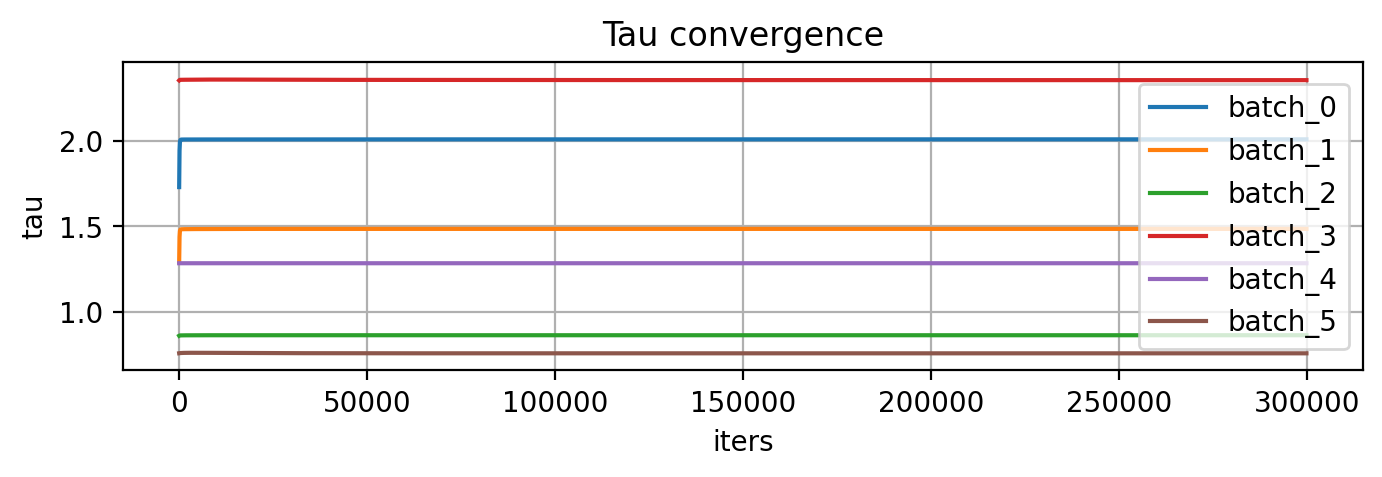

unconverged value of tau: [2.00813608 1.48497561 0.8637244  2.35384388 1.28432978 0.75808579] after: 300000 iterations in: 103.5589s (0.0003 s/iter)
GPU-RAM currently 8.09 MB (max allocated 11.09 MB; 23.07 MB reserved)


In [4]:
s = tau.PeriodicElectrodeSolver(batch, device='cuda')
tau_electrode = s.solve(iter_limit=300000, conv_crit=1e-6, plot_interval=100, verbose='debug')

Save results to dictionaries

In [5]:
vol_x = {}
a_x = {}
tau_x = {}
c_x = {}
for i, structure in enumerate(structures):
    vol_x[structure] = s.vol_x[i]
    a_x[structure] = s.a_x[i]
    tau_x[structure] = s.tau_x[i]
    name = structure + "_c"
    c_x[name] = s.c_x[i]
    fields[name] = s.field[i,1:-1,1:-1,1:-1].cpu().numpy()

## Classic $\tau_c$ reference

Iter: 300000, conv error: 1.606E-03, tau: 1.59586 (batch element 2)


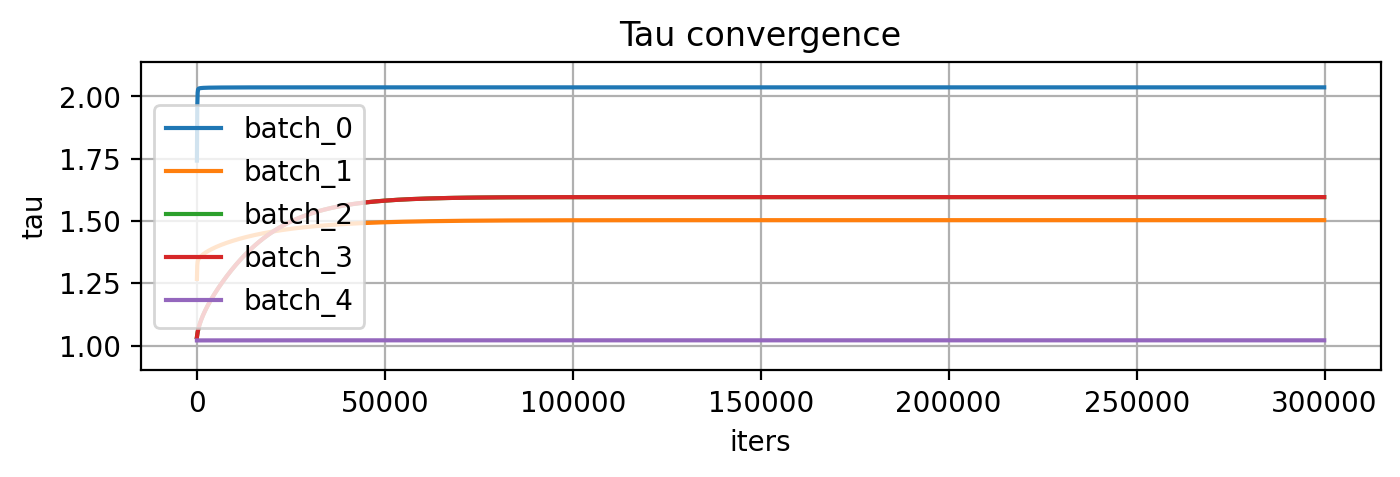

unconverged value of tau: [2.0364084 1.5033146 1.5958596 1.5958687 1.0209299 0.       ] after: 300000 iterations in: 110.5198s (0.0004 s/iter)
GPU-RAM currently 14.67 MB (max allocated 19.24 MB; 44.04 MB reserved)


In [6]:
t = tau.PeriodicSolver(batch, device='cuda')
tau_classic = t.solve(iter_limit=300000, conv_crit=1e-6, verbose='debug', plot_interval=100)

In [7]:
tau_x_classic = {}
for i, structure in enumerate(structures):
    tau_x_classic[structure] = t.tau_x[i]
    name = structure + "_c_classic"
    c_x[name] = 0.5-t.c_x[i]
    fields[name] = 0.5-t.field[i,1:-1,1:-1,1:-1].cpu().numpy()

## Result evaluation

We use the recursive TLM formula to compute the impedance resulting from the microstructural parameters $\epsilon(x)$, $a(x)$ and $\tau(x)$ and save them to dictionaries.

In [8]:
from taufactor.utils import compute_impedance

frequency_tau_x = {}
Z_TLM_tau_x = {}
Z_TLM_tau_mean = {}
for i, structure in enumerate(structures):
    # Compute impedance for heterogeneous distribution
    R = tau_x[structure] / vol_x[structure]
    R[vol_x[structure] == 0] = 1e30
    R[np.isnan(tau_x[structure])] = 1e30
    C = a_x[structure]

    freq_0 = np.mean(vol_x[structure]) / np.mean(C) / nx**2
    freq_range = freq_0 * 2 ** np.arange(-3, 10, 0.5)
    freq = freq_range[::-1].copy()
    frequency_tau_x[structure] = freq
    Z_TLM_tau_x[structure] = compute_impedance(R, C, freq)

    # Compute impedance for homogenized case
    R_mean = np.full(nx, 1/np.mean(vol_x[structure]))
    C_mean = np.full(nx, np.mean(C))
    Z_TLM_tau_mean[structure] = compute_impedance(R_mean, C_mean, freq)

(Optionally:) Load EIS simulation results (see more details at the end of this notebook)

In [9]:
import pickle

Z_EIS = {}
for structure in structures:
    filename = "impedance_solve_" + structure + ".pkl"
    with open(filename, "rb") as f:
        data = pickle.load(f)
        Z_EIS[structure] = data.impedance

Create master plot of results

In [10]:
a_x['wedge'][1:-1] = np.mean(a_x['wedge'][1:-1])

/tmp/ipykernel_540654/2035934709.py:76: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


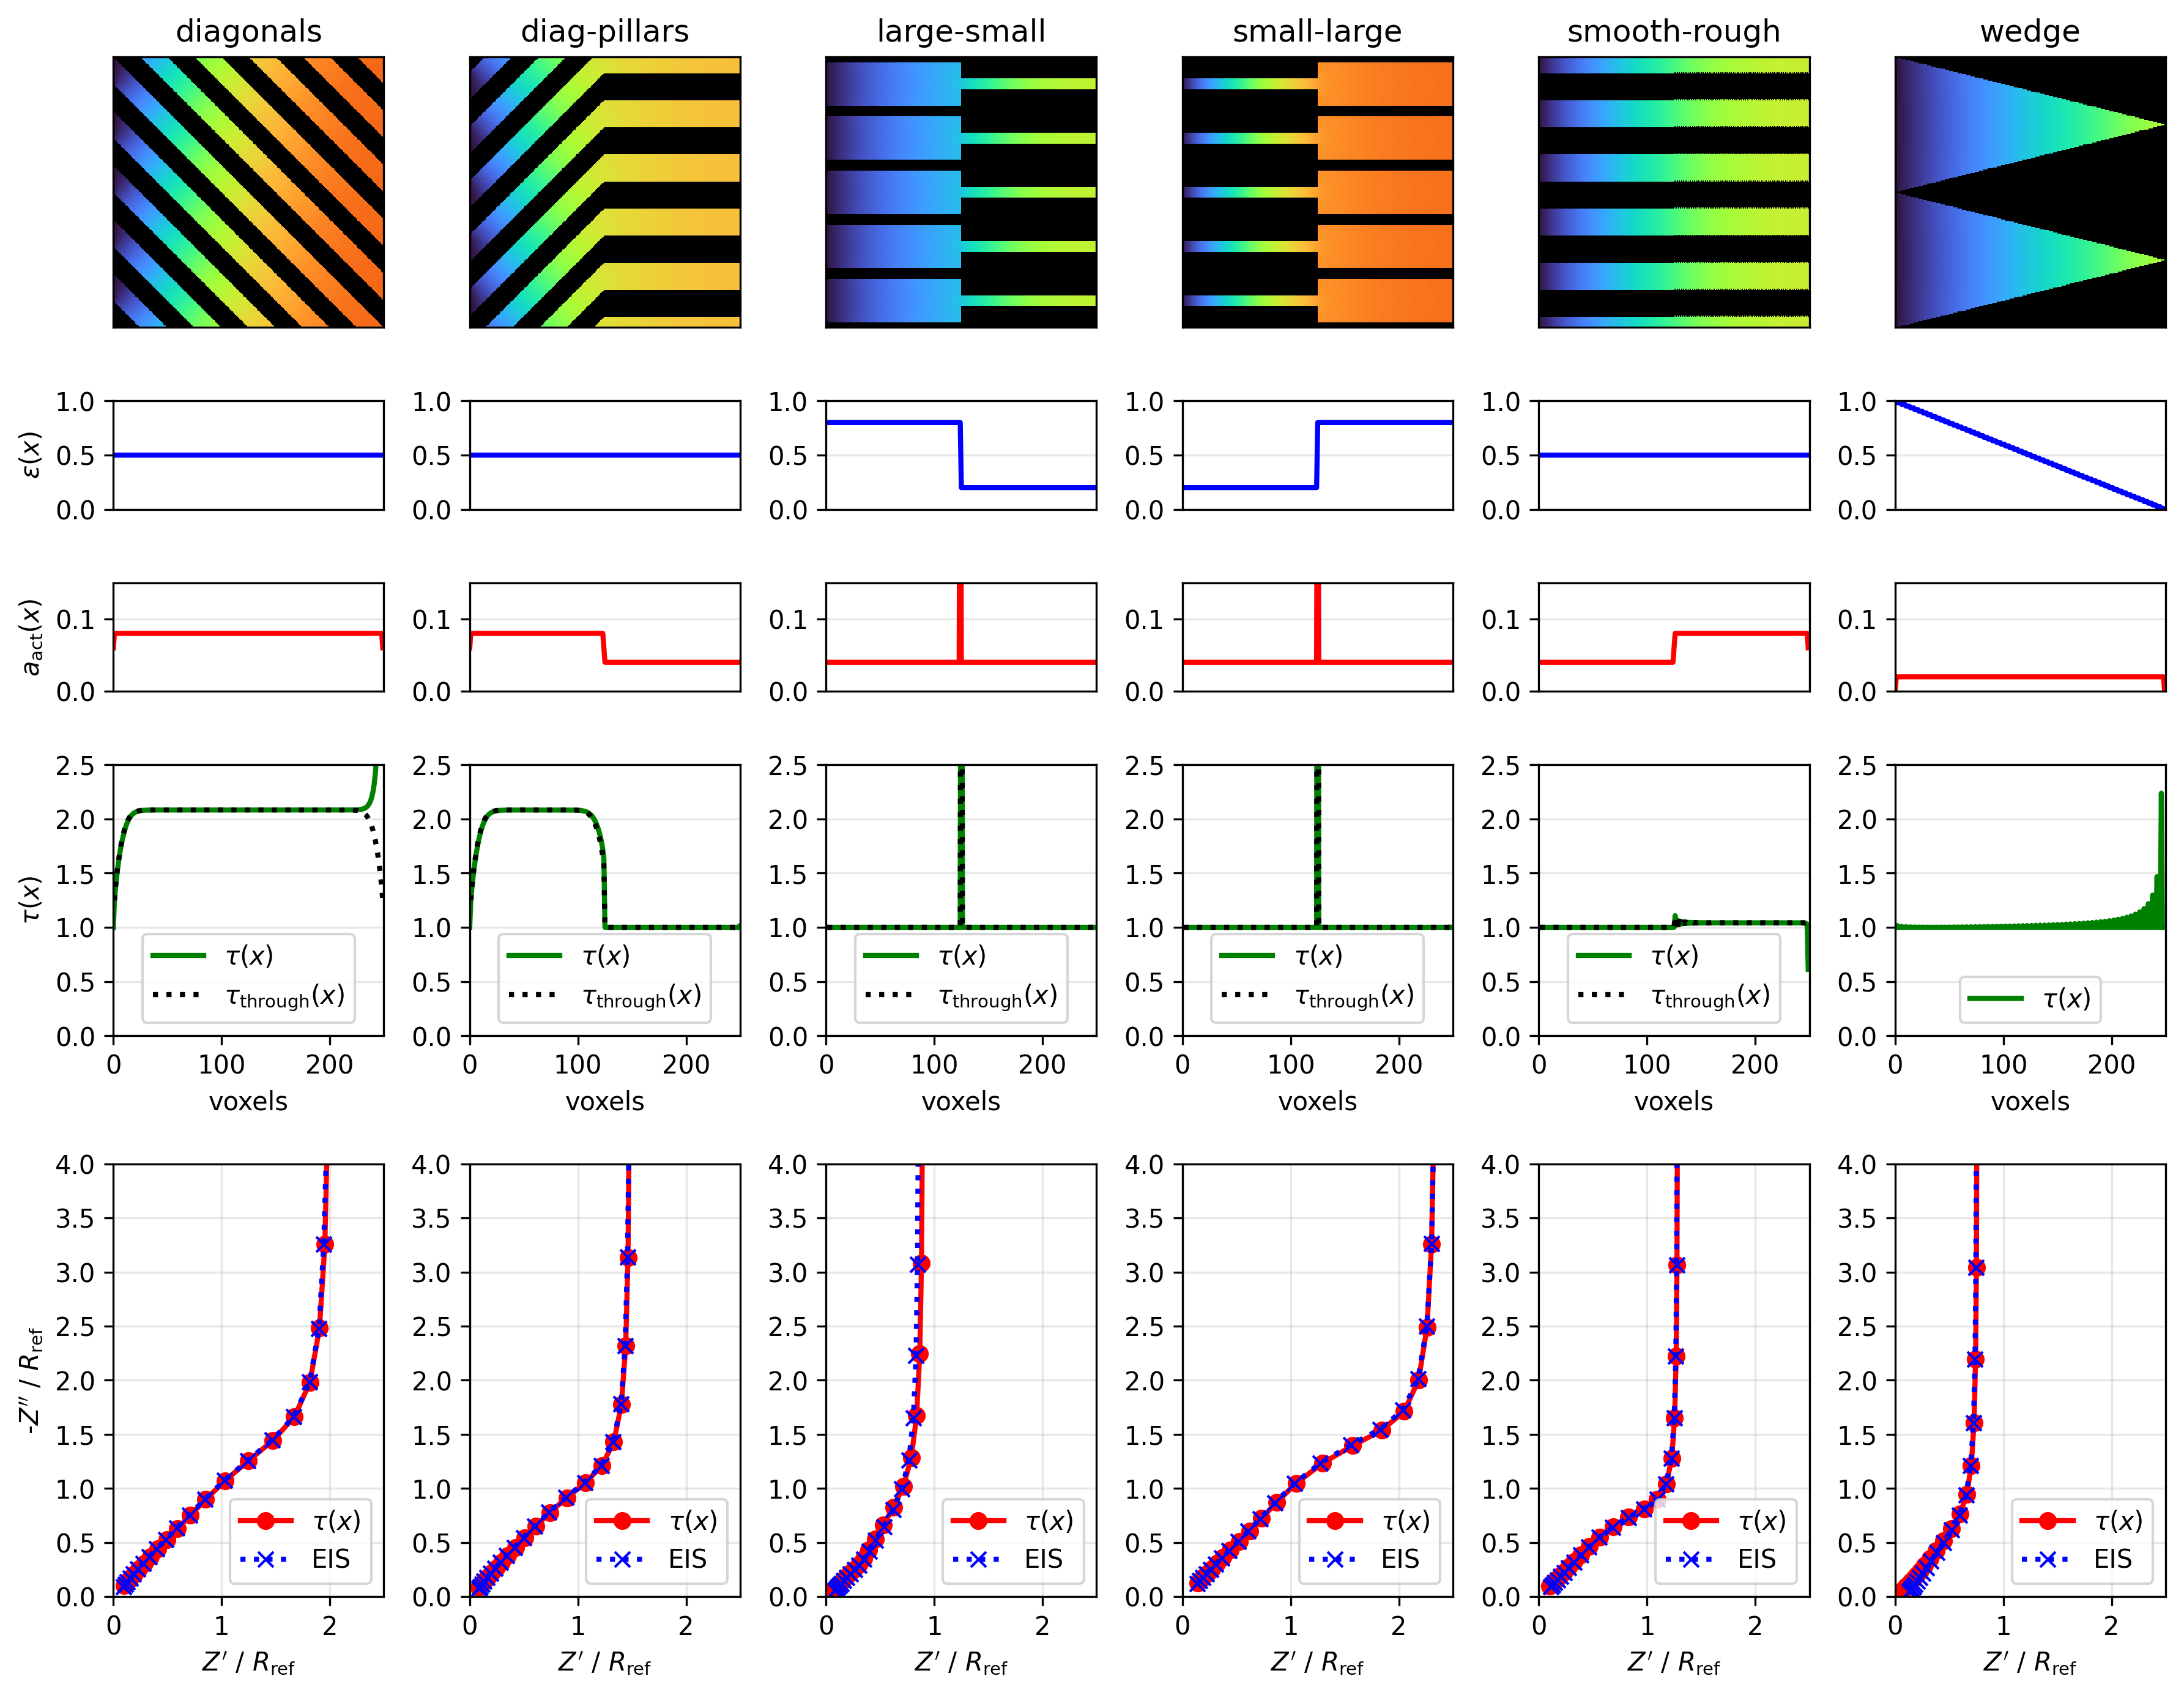

In [11]:
from matplotlib.ticker import FormatStrFormatter
fig, axes = plt.subplots(nrows=5, ncols=6, figsize=(12, 9.4), dpi=300,
                         constrained_layout=True,
                         gridspec_kw={'height_ratios': [1.0, 0.4, 0.4, 1, 2]})
for i, structure in enumerate(structures):
    lw = 2
    name = structure + "_c"
    data1 = fields[name][:, :, 0].T
    data2 = fields[structure][:, :, 0].T
    alpha = np.clip(data2==0, 0, 1).astype(float)
    axes[0, i].imshow(data1, cmap='turbo_r', interpolation='none', vmin=0.3, vmax=1)
    axes[0, i].imshow(data2, cmap='gray', interpolation='none', alpha=alpha)
    axes[0, i].set_aspect('equal')
    axes[0, i].set_title(structure)
    axes[0, i].set_xlim(0, nx)
    axes[0, i].set_ylim(0, nx)
    axes[0, i].set_xticks([])
    axes[0, i].set_yticks([])

    ax_line = axes[1, i]
    vx = np.asarray(vol_x[structure]).squeeze()
    xv = np.linspace(0, nx, num=vx.size, endpoint=False)
    ax_line.plot(xv, vx, color='blue', linewidth=lw)
    ax_line.set_xlim(0, nx)
    ax_line.set_ylim(0, 1)
    axes[1, i].set_xticks([])
    ax_line.grid(True, alpha=0.3)

    ax_line = axes[2, i]
    vx = np.asarray(a_x[structure]).squeeze()
    xv = np.linspace(0, nx, num=vx.size, endpoint=False)
    ax_line.plot(xv, vx, color='red', linewidth=lw)
    ax_line.set_xlim(0, nx)
    ax_line.set_ylim(0, 0.15)
    ax_line.set_yticks([0,0.1])
    ax_line.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    axes[2, i].set_xticks([])
    ax_line.grid(True, alpha=0.3)

    ax_line = axes[3, i]
    vx = np.asarray(tau_x[structure]).squeeze()
    xv = np.linspace(0, nx, num=vx.size, endpoint=False)
    ax_line.plot(xv, vx, color='green', label='$\\tau(x)$', linewidth=lw)
    vx = np.asarray(tau_x_classic[structure]).squeeze()
    if vx[0] != 0:
        ax_line.plot(xv[1:], vx, color='black', linestyle=':', label='$\\tau_\\text{through}(x)$', linewidth=lw)
    ax_line.set_xlim(0, nx)
    ax_line.set_ylim(0, 2.5)
    ax_line.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax_line.grid(True, alpha=0.3, axis='y')
    ax_line.legend(loc='lower center')

    axes[1, 0].set_ylabel('$\\epsilon(x)$')
    axes[2, 0].set_ylabel('$a_\\text{act}(x)$')
    axes[3, 0].set_ylabel('$\\tau(x)$')
    ax_line.set_xlabel('voxels')

    ax_line = axes[4, i]
    Z = Z_TLM_tau_x[structure]
    Z_mean = Z_TLM_tau_mean[structure]
    scale = Z_mean[-1].real
    ax_lim = 1.2*np.max([Z.real, Z_mean.real])/scale

    ax_line.plot(Z.real/scale, -Z.imag/scale, color='red', linestyle='-', marker='o', label='$\\tau(x)$', linewidth=lw)
    Z = Z_EIS[structure]
    ax_line.plot(np.real(Z)/scale, -np.imag(Z)/scale, color='blue', linestyle=':', marker='x', label='EIS', linewidth=lw)

    ax_line.set_xlim(0, 2.5)
    ax_line.set_ylim(0, 4)
    ax_line.set_aspect('equal')
    ax_line.set_xlabel("$Z'$ / $R_\\text{ref}$")
    axes[4,0].set_ylabel("-$Z''$ / $R_\\text{ref}$")
    ax_line.legend(loc='lower right')
    ax_line.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Calculate the averaged classical tortuosity factor $\tau_c$

... for the through-transport simulation $\tau_\text{through}(x)$

In [12]:
t_ref = t.tau_x
eps = 0.5*(t.vol_x[:,1:] + t.vol_x[:,:-1])
tau_c = np.mean(t_ref/eps, axis=1) * np.mean(eps, axis=1)
print(tau_c)

[2.0405836 1.5054078 1.5963418 1.5963416 1.0210164 0.       ]


## Detailed comparison of $\tau(x)$ vs scalar metrics

In [13]:
def mean_staggered_x_grid(field):
    average = np.sum(field[1:-1]) \
                     + 0.5*np.sum(field[ 0]) \
                     + 0.5*np.sum(field[-1])
    average /= (field.shape[0] - 1)
    return average

In [14]:
from scipy.linalg import solve_banded

def solve_tridiagonal_system(N, D_mid, c_left, c_right):
    # Prepare tridiagonal matrix coefficients
    lower = -D_mid[:-1] # sub-diagonal (a_i)
    main  = (D_mid[:-1] + D_mid[1:]) # main diagonal (b_i)
    upper = -D_mid[1:] # super-diagonal (c_i)

    # Build banded matrix (required by solve_banded)
    ab = np.zeros((3, N-2))
    ab[0, 1:] = upper[:-1]   # upper diagonal
    ab[1, :]  = main         # main diagonal
    ab[2, :-1] = lower[1:]   # lower diagonal

    # RHS vector
    b = np.zeros(N-2)
    b[0] += D_mid[0] * c_left
    b[-1] += D_mid[-1] * c_right # usually zero

    # Solve the linear system
    c_internal = solve_banded((1,1), ab, b)

    # Construct full concentration array
    c = np.zeros(N)
    c[0] = c_left
    c[1:-1] = c_internal
    c[-1] = c_right
    return c

def solve_steady_state_c(D_mid, c_left=1, c_right=0):
    N = len(D_mid) + 1
    if np.any(D_mid==0):
        return c_left*np.zeros(N)
    else:
        c = solve_tridiagonal_system(N, D_mid, c_left, c_right)
        return c

def solve_tridiagonal_reactive_zero_flux(N, D_mid, a_mid, c_left, c0):
    dx = 1 / (N - 1)  # adjust if physical length L is different

    # Prepare tridiagonal matrix coefficients
    lower = -D_mid[:-1] / dx**2  # sub-diagonal
    main  = (D_mid[:-1] + D_mid[1:]) / dx**2 + a_mid  # main diagonal with reaction term
    upper = -D_mid[1:] / dx**2  # super-diagonal

    # Adjust coefficients for zero-flux boundary at right boundary
    main[-1] = D_mid[-2] / dx**2 + a_mid[-1]  # modify the last diagonal entry

    # Build banded matrix for solve_banded
    ab = np.zeros((3, N-2))
    ab[0, 1:] = upper[:-1]     # upper diagonal
    ab[1, :]  = main           # main diagonal
    ab[2, :-1] = lower[1:]     # lower diagonal

    # RHS vector with reaction/source term
    b = a_mid * c0
    b[0] += D_mid[0] * c_left / dx**2

    # Solve the linear system
    c_internal = solve_banded((1,1), ab, b)

    # Construct full concentration array
    c = np.zeros(N)
    c[0] = c_left
    c[1:-1] = c_internal
    c[-1] = c[-2]  # Enforce zero-flux by setting last concentration equal to the second-to-last

    return c

def solve_steady_state_reactive_zero_flux(D_mid, a, c_left=1, c0=0):
    N = len(D_mid) + 1
    a_mid = 0.5*(a[1:]+a[:-1])
    c = solve_tridiagonal_reactive_zero_flux(N, D_mid, a_mid, c_left, c0)
    return c

/tmp/ipykernel_540654/3708062810.py:53: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


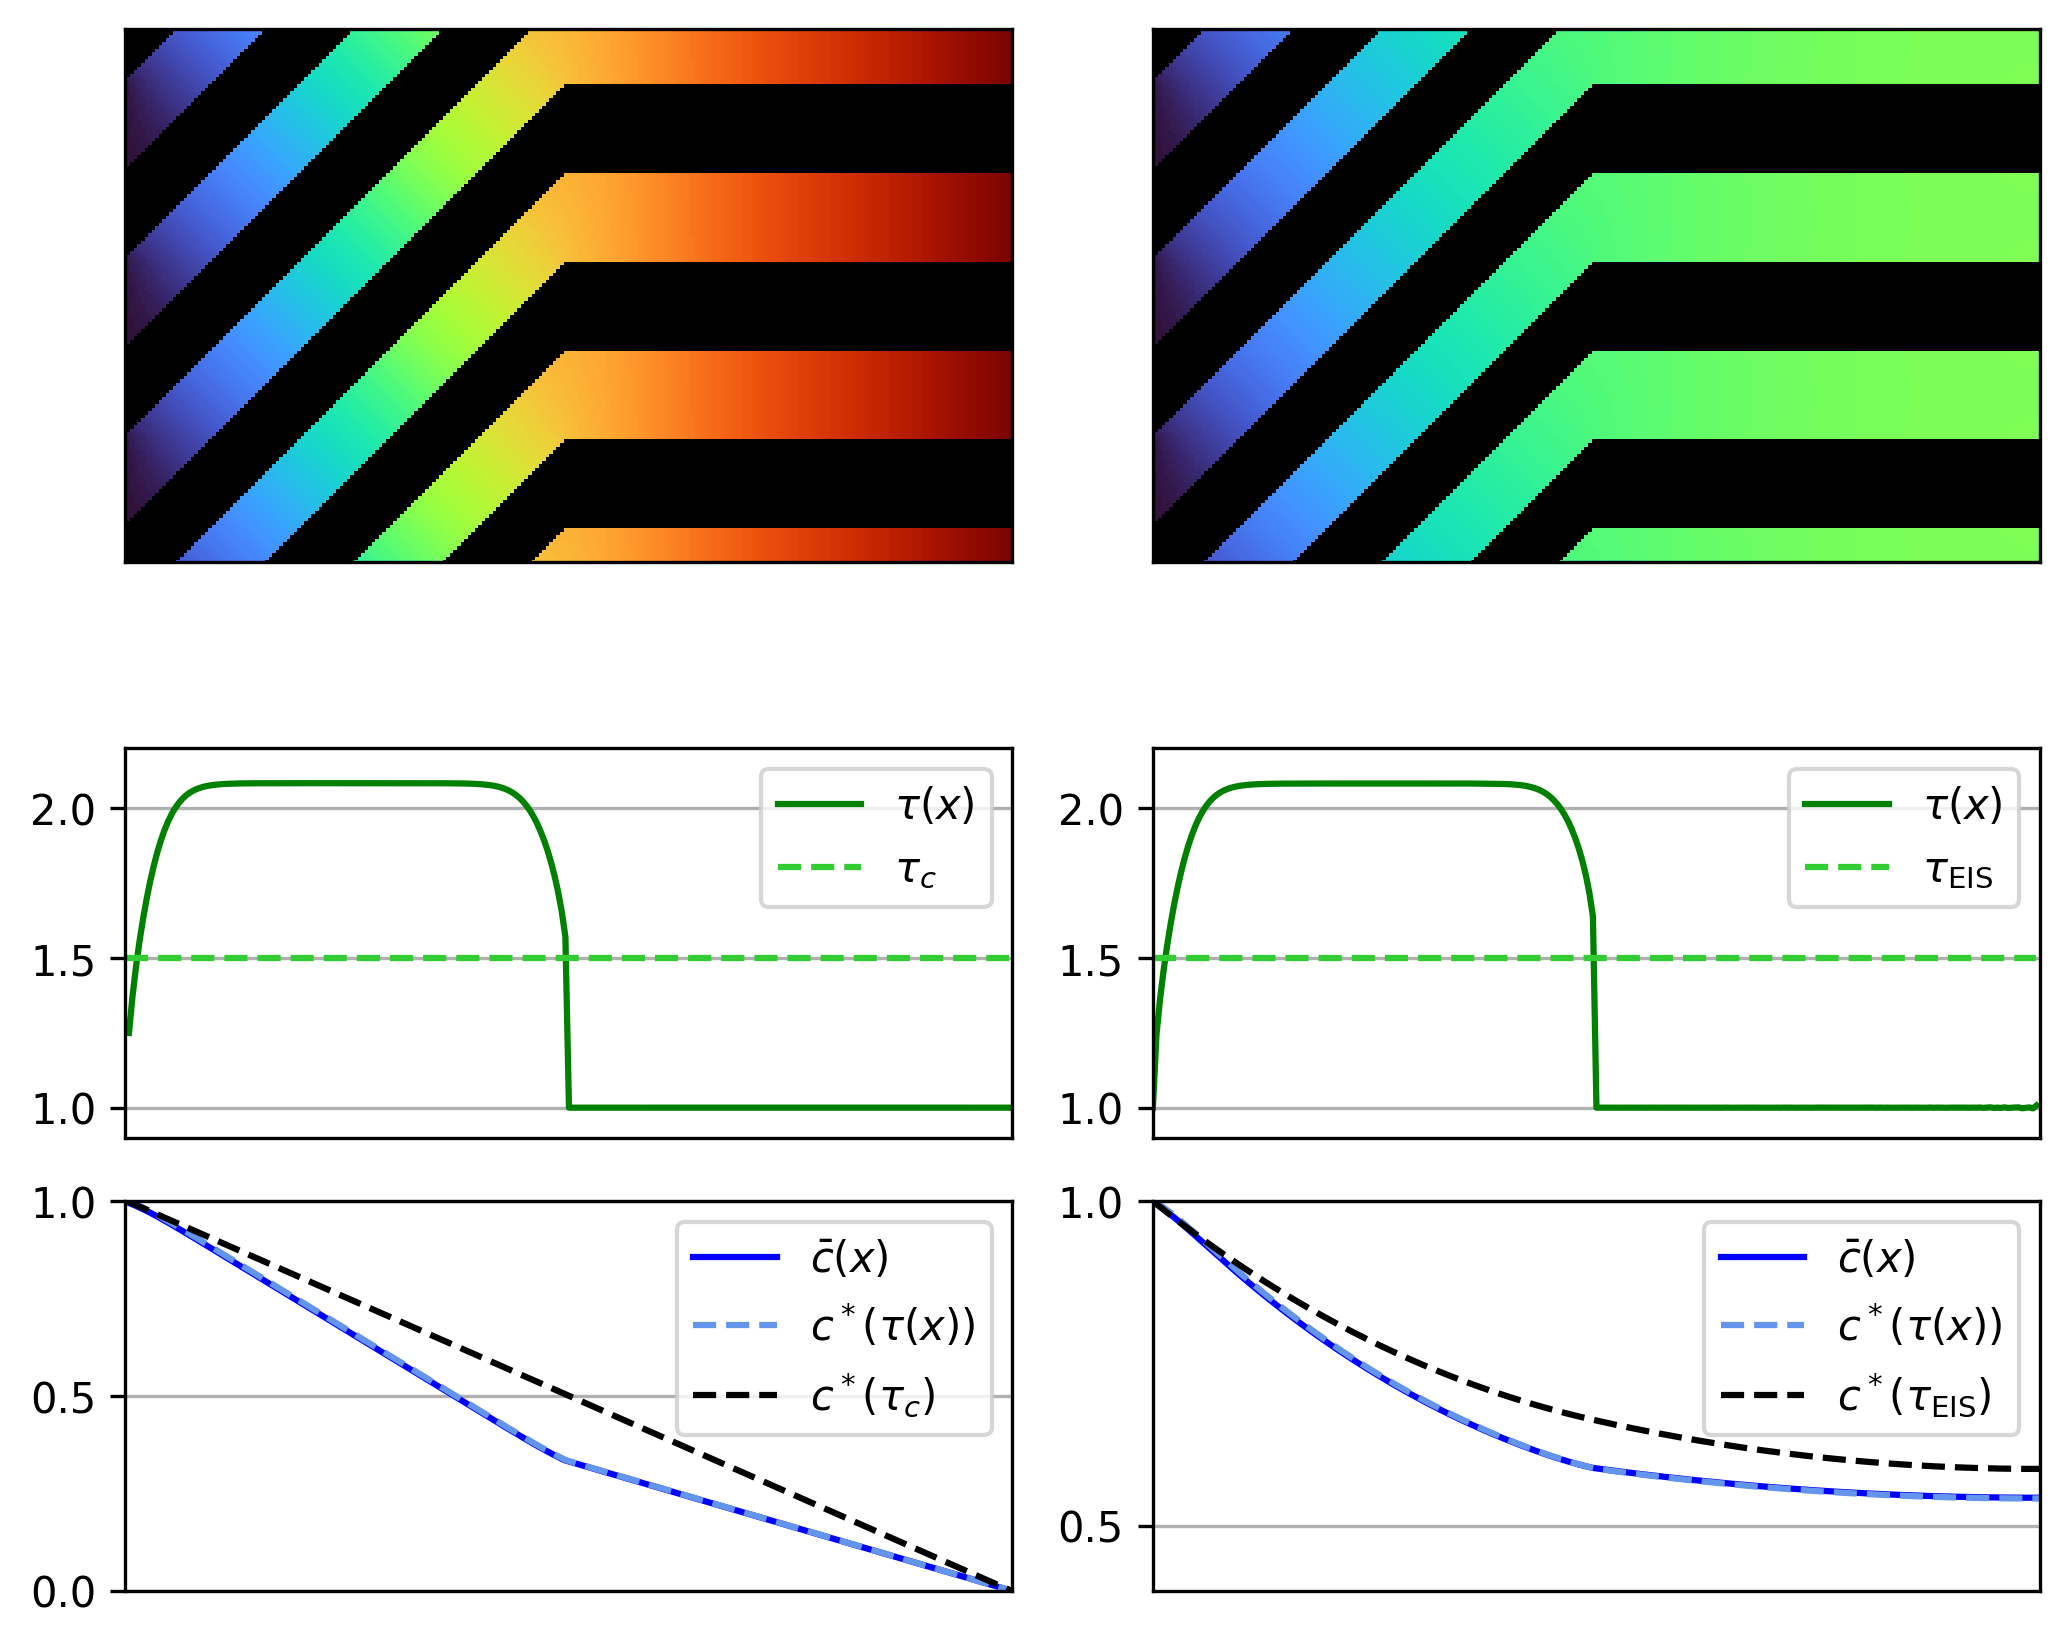

In [15]:
structure = 'diag-pillars'
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(7, 6), dpi=300,
                       constrained_layout=True,
                       gridspec_kw={'height_ratios': [1.0, 0.5, 0.5]})

for i, suffix in enumerate(['_c_classic', '_c']):
    data1 = fields[structure+suffix][:, :150, 0].T
    data2 = fields[structure][:, :150, 0].T
    alpha = np.clip(data2==0, 0, 1).astype(float)
    ax[0, i].imshow(data1, cmap='turbo_r', interpolation='none', vmin=0, vmax=1)
    ax[0, i].imshow(data2, cmap='gray', interpolation='none', alpha=alpha)
    ax[0, i].set_aspect('equal')
    ax[0, i].set_xlim(0, nx)
    ax[0, i].set_ylim(0, 150)
    ax[0, i].set_xticks([])
    ax[0, i].set_yticks([])

dx = 1 / nx
x = np.arange(0, nx)+0.5
ax[1,0].plot(np.arange(1, nx), tau_x_classic[structure], label='$\\tau(x)$', color='green', linestyle='-')
ax[1,0].plot(np.arange(0, nx), 1.5*np.ones(nx), label='$\\tau_c$', color='limegreen', linestyle='--')
ax[1,1].plot(np.arange(0, nx), tau_x[structure], label='$\\tau(x)$', color='green', linestyle='-')
ax[1,1].plot(np.arange(0, nx), 1.5*np.ones(nx), label='$\\tau_\\text{EIS}$', color='limegreen', linestyle='--')

for i, suffix in enumerate(['_c_classic', '_c']):
    ax[2,i].plot(np.arange(0, 250), c_x[structure+suffix], label='$\\bar{c}(x)$', color='blue', linestyle='-')

c_tau = solve_steady_state_c(0.5*(vol_x[structure][:-1]+vol_x[structure][1:])/tau_x_classic[structure])
ax[2,0].plot(x, c_tau, label='$c^*(\\tau(x))$', color='cornflowerblue', linestyle='--')
c_tau = solve_steady_state_c(0.5/1.5*np.ones(nx-1))
ax[2,0].plot(x, c_tau, label='$c^*(\\tau_c)$', color='black', linestyle='--')
k0 = np.mean(vol_x[structure]) / np.mean(a_x[structure]) #/ nx**2
c_tau = solve_steady_state_reactive_zero_flux(vol_x[structure]/tau_x[structure], k0*a_x[structure])
ax[2,1].plot(np.arange(0, 251), c_tau, label='$c^*(\\tau(x))$', color='cornflowerblue', linestyle='--')
c_tau = solve_steady_state_reactive_zero_flux(0.5/1.5*np.ones(nx), k0*a_x[structure])
ax[2,1].plot(np.arange(0, 251), c_tau, label='$c^*(\\tau_\\text{EIS})$', color='black', linestyle='--')

for i, suffix in enumerate(['_c_classic', '_c']):
    ax[1,i].set_xlim(0, 250)
    ax[2,i].set_xlim(0, 250)
    ax[1, i].set_xticks([])
    ax[2, i].set_xticks([])
    ax[1,i].set_ylim(0.9, 2.2)
    ax[1,i].legend(loc='upper right')
    ax[2,i].legend(loc='upper right')
    ax[1,i].grid()
    ax[2,i].grid()
    ax[2,i].set_yticks([0,0.5, 1])
ax[2,0].set_ylim(0, 1)
ax[2,1].set_ylim(0.4, 1)


plt.tight_layout()
plt.show()

## Simulated electrochemical impedance $\tau_{EIS}$

Save option as these simulations take ages (double precision necessary, solve for every frequency and currently not parallelised by batching...)

In [ ]:
from pathlib import Path
def save_solver_object(s, path_base):
    path_base = Path(path_base)
    path_base.parent.mkdir(parents=True, exist_ok=True)
    pkl_path = path_base.with_suffix(".pkl")

    try:
        import dill as _pickle
    except ImportError:  # fallback
        import pickle as _pickle

    with open(pkl_path, "wb") as f:
        # Use highest protocol available (pickle>=5 handles big numpy arrays efficiently)
        _pickle.dump(s, f, protocol=getattr(_pickle, "HIGHEST_PROTOCOL", 4))
    return pkl_path

In [ ]:
a = tau.PeriodicImpedanceSolver(fields['diagonals'], mode='nyquist')
a.solve(iter_limit=500000, conv_crit=-1, verbose='plot', plot_interval=100)
pkl_path = save_solver_object(a, "impedance_solve_diagonals")

In [ ]:
b = tau.PeriodicImpedanceSolver(fields["diag-pillars"], mode='nyquist')
b.solve(iter_limit=500000, conv_crit=-1, verbose='plot', plot_interval=100)
pkl_path = save_solver_object(b, "impedance_solve_diag-pillars")

In [ ]:
c = tau.PeriodicImpedanceSolver(fields["large-small"], mode='nyquist')
c.solve(iter_limit=1000000, conv_crit=-1, verbose='plot', plot_interval=100)
pkl_path = save_solver_object(c, "impedance_solve_large-small")

In [ ]:
d = tau.PeriodicImpedanceSolver(fields["small-large"], mode='nyquist')
d.solve(iter_limit=1000000, conv_crit=-1, verbose='plot', plot_interval=100)
pkl_path = save_solver_object(d, "impedance_solve_small-large")

In [ ]:
e = tau.PeriodicImpedanceSolver(fields["smooth-rough"], mode='nyquist')
e.solve(iter_limit=500000, conv_crit=-1, verbose='plot', plot_interval=100)
pkl_path = save_solver_object(e, "impedance_solve_smooth-rough")

In [ ]:
f = tau.PeriodicImpedanceSolver(fields["wedge"], mode='nyquist')
f.solve(iter_limit=1000000, conv_crit=-1, verbose='plot', plot_interval=100)
pkl_path = save_solver_object(f, "impedance_solve_wedge")